# Generative AI for Synthetic Data Augmentation

High-quality labeled data is often expensive or impossible to collect at scale. Collecting real-world samples for rare clothing items or specific handwritten digits is time-consuming and costly.

This project implements a generative pipeline to automate the creation of synthetic training data. We evaluate our models across two distinct domains: Numerical Data (MNIST) and Retail/Fashion Data (Fashion-MNIST)


Datasets Used:
Fashion MNIST - https://www.kaggle.com/datasets/zalando-research/fashionmnist \
MNIST - https://www.kaggle.com/datasets/hojjatk/mnist-dataset



Importing neccessary libraries

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import ssl
import matplotlib.pyplot as plt
import torchvision

# bypass the ssl verification for just downloading the dataset
ssl._create_default_https_context = ssl._create_unverified_context

# add a reliable fallback mirror for MNIST (just in case)
MNIST.mirrors = ["https://ossci-datasets.s3.amazonaws.com/mnist/"]


## Data Loading and Visualizing


In [22]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
batch_size = 128


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [23]:
def load_data(mode):
    if mode == 'digits':
        train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
    else:
        train_data = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)

    return DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [24]:
mnist_train = load_data('digits')
print(mnist_train.dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [25]:
fashion_train = load_data('fashion')
print(fashion_train.dataset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


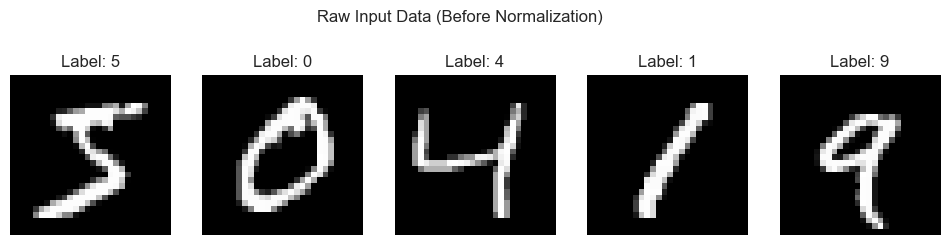

In [6]:
raw_transform = transforms.Compose([transforms.ToTensor()])

raw_digits = datasets.MNIST('./data', train=True, download=True, transform=raw_transform)

# visualizing the before state of the dataset
plt.figure(figsize=(12,3))
for i in range(5):
    img, label = raw_digits[i]
    plt.subplot(1,5,i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.suptitle("Raw Input Data (Before Normalization)")
plt.show()

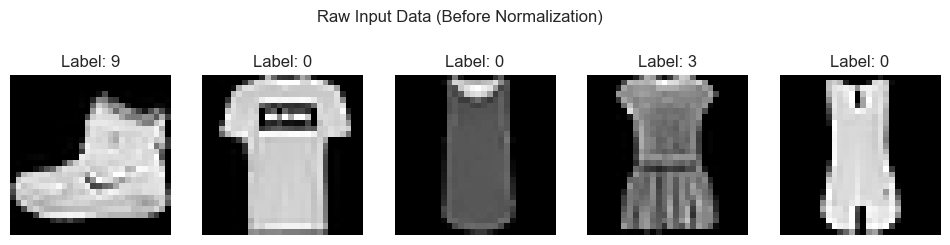

In [7]:
raw_fashion = datasets.FashionMNIST('./data', train=True, download=True, transform=raw_transform)

plt.figure(figsize=(12,3))
for i in range(5):
    img, label = raw_fashion[i]
    plt.subplot(1,5,i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.suptitle("Raw Input Data (Before Normalization)")
plt.show()

## Data Transformation

Neural networks perform best when data is centered at zero with a standard deviation of one. We apply a Tanh-compatible transformation (scaling pixels from [0, 1] to [-1, 1]) to prepare the data for the Generator's final activation layer.

Processed Batch Shape: torch.Size([128, 1, 28, 28])
Processed Pixel Range: Min -1.00, Max 1.00


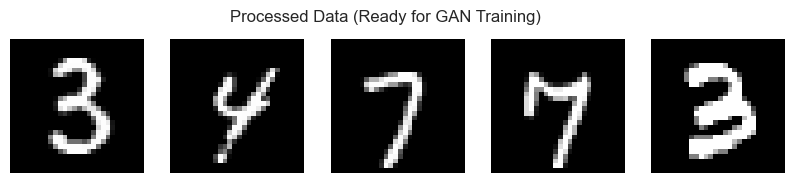

In [8]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # scaling to [-1, 1]
])

mnist_train = load_data('digits')

sample_batch, _ = next(iter(mnist_train))
print(f"Processed Batch Shape: {sample_batch.shape}")
print(f"Processed Pixel Range: Min {sample_batch.min():.2f}, Max {sample_batch.max():.2f}")

plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_batch[i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.suptitle("Processed Data (Ready for GAN Training)")
plt.show()

Processed Batch Shape: torch.Size([128, 1, 28, 28])
Processed Pixel Range: Min -1.00, Max 1.00


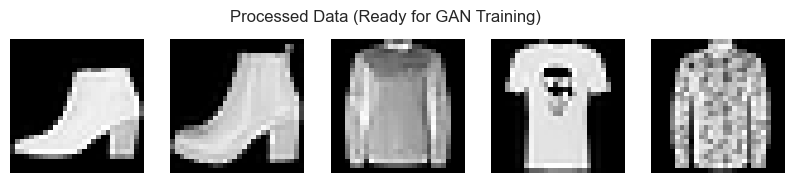

In [9]:
fashion_train = load_data('fashion')

sample_batch, _ = next(iter(fashion_train))
print(f"Processed Batch Shape: {sample_batch.shape}")
print(f"Processed Pixel Range: Min {sample_batch.min():.2f}, Max {sample_batch.max():.2f}")

plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_batch[i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.suptitle("Processed Data (Ready for GAN Training)")
plt.show()

## Feature Extraction via Autoencoders

We deploy an Autoencoder to learn the latent representations of both datasets. For MNIST, the model focuses on stroke patterns; for Fashion-MNIST, it learns to prioritize "silhouette-defining" features. If the model can reconstruct the image from just 20 numbers, it has successfully performed Feature Extraction.


### Architectural Choices

We compress the 784-pixel input into a 20-dimensional latent space. This forces the model to perform non-linear dimensionality reduction. LeakyRelu is applied to maintain gradient flow during backpropagation, preventing dead neurons on negative inputs. Tanh activation is chosen for the final output layer to align with our normalized [-1, 1] data distribution.



In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 20),
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 784),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model_ae = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_ae.parameters(), lr=0.001)

In [11]:
def train_autoencoder(train_loader, num_epochs):
    losses = []

    for epoch in range(num_epochs):
        total_loss = 0
        for data, _ in train_loader:
            img = data.to(device)

            # forward pass
            output = model_ae(img)
            loss = criterion(output, img.view(-1, 784))

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)

        if (epoch+1) % 5 == 0:
            print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {avg_loss:.3f}")

    plt.plot(losses)
    plt.title("Reconstruction Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.show()

Epoch: 5/25, Loss: 0.043
Epoch: 10/25, Loss: 0.036
Epoch: 15/25, Loss: 0.033
Epoch: 20/25, Loss: 0.031
Epoch: 25/25, Loss: 0.030


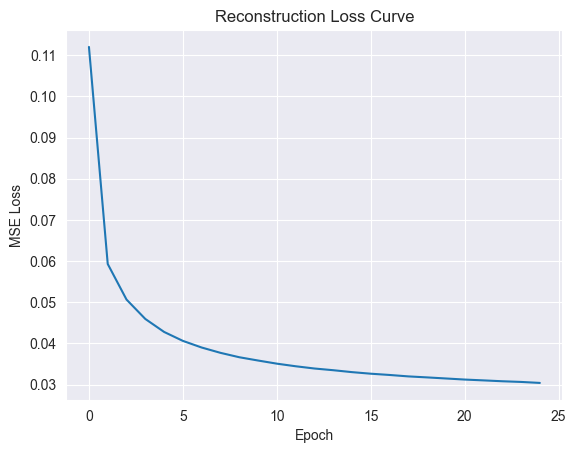

In [12]:
# training autoencoder on mnist data
train_autoencoder(mnist_train, 25)


Epoch: 5/15, Loss: 0.046
Epoch: 10/15, Loss: 0.042
Epoch: 15/15, Loss: 0.040


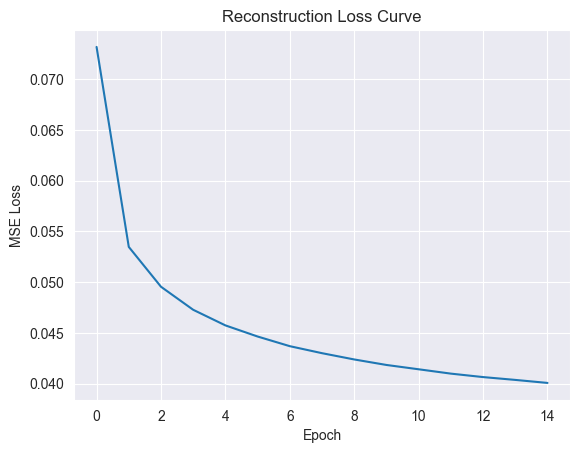

In [13]:
# training autoencoder on fashion mnist data
train_autoencoder(fashion_train, 15)

## Validation

We compare the Raw Inputs with their Reconstructed Outputs. If the model can regenerate a clear digit from just 20 latent variables, it is ready to serve as a feature extractor.

In [14]:
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# load MNIST Test
test_set_digits = datasets.MNIST('./data', train=False, download=True, transform=test_transform)
test_loader_digits = DataLoader(test_set_digits, batch_size=10, shuffle=True)

# load Fashion Test
test_set_fashion = datasets.FashionMNIST('./data', train=False, download=True, transform=test_transform)
test_loader_fashion = DataLoader(test_set_fashion, batch_size=10, shuffle=True)


In [15]:
def validate_reconstruction(model, loader, title):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(loader))
        data = data.to(device)
        output = model(data)

        plt.figure(figsize=(12, 4))
        for i in range(5):
            # original
            plt.subplot(2, 5, i + 1)
            plt.imshow(data[i].cpu().squeeze(), cmap='gray')
            plt.axis('off')
            if i == 0: plt.title("Original (Test Set)")

            # reconstructed
            plt.subplot(2, 5, i + 6)
            plt.imshow(output[i].cpu().view(28, 28), cmap='gray')
            plt.axis('off')
            if i == 0: plt.title("Reconstructed")

        plt.suptitle(f"{title}")
        plt.show()

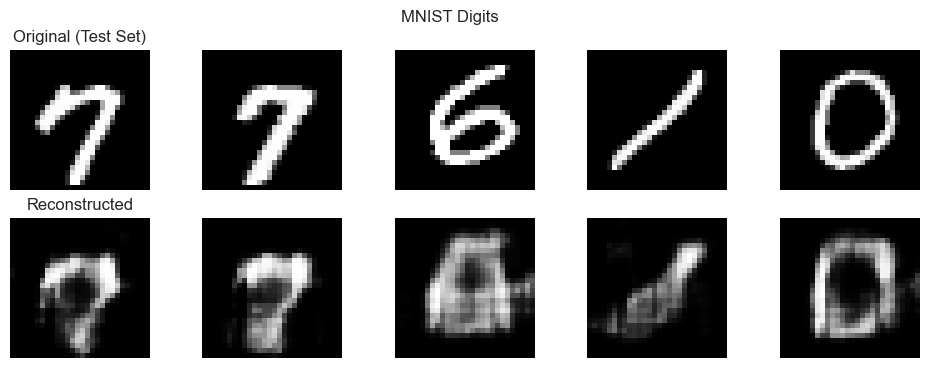

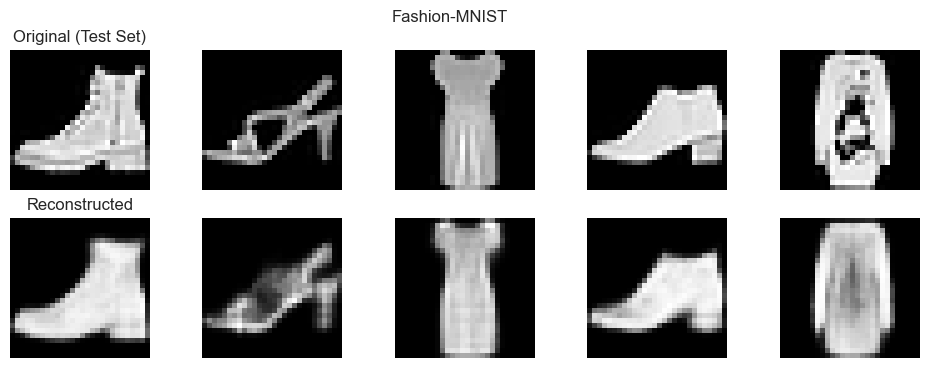

In [16]:
validate_reconstruction(model_ae, test_loader_digits, "MNIST Digits")
validate_reconstruction(model_ae, test_loader_fashion, "Fashion-MNIST")

Before proceeding to adversarial generation, we evaluate the Autoencoder's ability to reconstruct unseen data from the test set. This validates whether the 20-dimensional latent space is sufficient to capture the semantics of the input domains.

The model did great with clothes. Because shirts and shoes are big, solid shapes, the model easily remembered their outlines.

The numbers came out blurry. Since numbers are just thin lines, the latent space wasn't detailed enough to keep the edges sharp. It learned the idea of a number but lost the fine details.

## Generative Adversarial Networks (GAN)
Unlike the Autoencoder’s pixel-to-pixel matching, the GAN uses Adversarial Training.

We are no longer compressing real images; we are training a Generator to turn random noise into digits and clothing that look real enough to fool a Discriminator.

### The Adversarial Architecture

The Generator: Learns to map a 64-dimensional noise vector ($z$) to a 784-pixel image.\
The Discriminator: A binary classifier that learns to distinguish between "Real" (from the dataset) and "Fake" (from the Generator).

Goal: To reach a Nash Equilibrium where the Discriminator has a 50% accuracy rate, meaning it can no longer tell the difference between real and synthetic data.


In [72]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.model(x)
        return x


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z):
            x = self.model(z)
            x = x.view(-1, 1, 28, 28)
            return x




In [67]:
net_g = Generator().to(device)
net_d = Discriminator().to(device)

criterion = nn.BCELoss() # binary cross entropy for the real/fake discrimination
optimizer_d = optim.Adam(net_d.parameters(), lr=0.002, betas=(0.5, 0.999))
optimizer_g = optim.Adam(net_g.parameters(), lr=0.002, betas=(0.5, 0.999))

In [73]:
def train_gan(num_epochs, train_loader):
    for epoch in range(num_epochs):
        for i, (real_imgs, _) in enumerate(train_loader):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)


            net_d.zero_grad()

            # real Labels
            labels_real = torch.ones(batch_size, 1, device=device)
            output_real = net_d(real_imgs)
            loss_d_real = criterion(output_real, labels_real)

            # fake Labels
            noise = torch.randn(batch_size, 64, device=device)
            fake_imgs = net_g(noise)
            labels_fake = torch.zeros(batch_size, 1, device=device)
            output_fake = net_d(fake_imgs.detach())
            loss_d_fake = criterion(output_fake, labels_fake)

            loss_d = loss_d_real + loss_d_fake
            loss_d.backward()
            optimizer_d.step()


            # maximize log(D(G(z)))
            net_g.zero_grad()

            noise = torch.randn(batch_size, 64, device=device) # for the generator to generate fresh fake imageas

            fake_imgs = net_g(noise)

            output_fake_for_g = net_d(fake_imgs)
            loss_g = criterion(output_fake_for_g, labels_real)

            loss_g.backward()
            optimizer_g.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")

## Analyzing GAN Synthesis
With the GAN reaching a stable state, we now sample the latent space. By passing random 64-dimensional noise vectors into the Generator, we produce images that do not exist in the original dataset.

In [69]:
num_epochs = 30
# training with mnist data
train_gan(num_epochs, mnist_train)

Epoch [10/30] | Loss D: 1.3517, Loss G: 0.8897
Epoch [20/30] | Loss D: 1.1964, Loss G: 1.0899
Epoch [30/30] | Loss D: 1.1228, Loss G: 1.4006


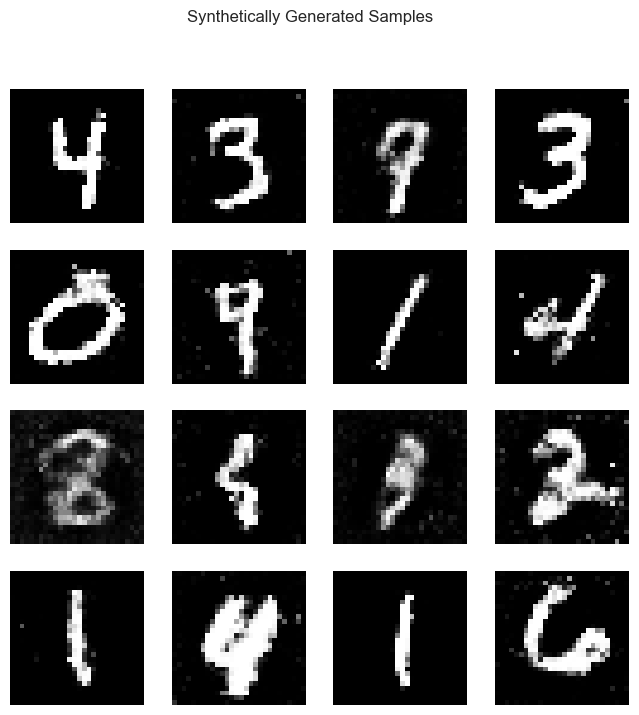

In [70]:
net_g.eval()
with torch.no_grad():

    noise = torch.randn(16, 64, device=device)
    samples = net_g(noise).cpu()


plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)

    plt.imshow(samples[i].squeeze() * 0.5 + 0.5, cmap='gray')
    plt.axis('off')
plt.suptitle("Synthetically Generated Samples")
plt.show()

In [74]:
# training with fashion mnist data
train_gan(num_epochs, fashion_train)

Epoch [10/30] | Loss D: 1.3614, Loss G: 0.6479
Epoch [20/30] | Loss D: 1.3172, Loss G: 1.5030
Epoch [30/30] | Loss D: 1.1848, Loss G: 1.1663


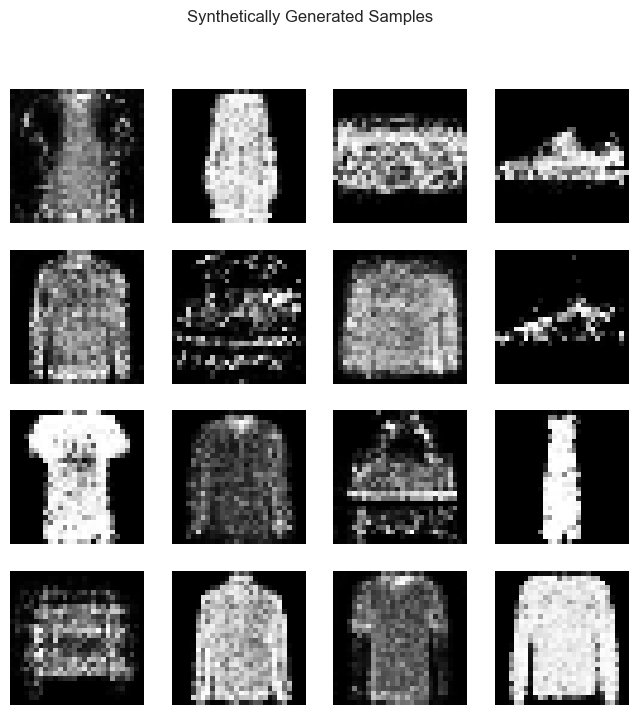

In [75]:
net_g.eval()
with torch.no_grad():

    noise = torch.randn(16, 64, device=device)
    samples = net_g(noise).cpu()


plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)

    plt.imshow(samples[i].squeeze() * 0.5 + 0.5, cmap='gray')
    plt.axis('off')
plt.suptitle("Synthetically Generated Samples")
plt.show()

## Model Persistance

We save the "learned weights" of our models so they can be reused for inference without retraining.


In [78]:
torch.save(net_g.state_dict(), 'gan_generator.pth')
torch.save(net_d.state_dict(), 'gan_discriminator.pth')
torch.save(model_ae.state_dict(), 'autoencoder.pth')

print("Success: All generative models saved as .pth files.")

Success: All generative models saved as .pth files.


## Final Analysis and Conclusion

Our objective was to develop a pipeline that can generate high-quality synthetic training data for a computer vision classifier. In real-world applications (like medical imaging or niche retail), obtaining large, high-variance datasets is often impossible due to cost or privacy.

The Strategy: We compared a "Fixed Distribution" approach (Autoencoders) against a "Competitive Distribution" approach (GANs)


While the Autoencoder achieved a lower mathematical loss in reconstruction, its output suffered from spectral bias (it averaged the pixels), leading to blurry edges. In a business context, training a classifier on blurry data leads to blurry results.

The GAN, despite being more unstable to train, learned the high-frequency components (sharp edges, textures) of the fashion dataset. It proved to be a superior tool for Synthetic Data Augmentation, providing sharper "fake" samples that are more effective for training downstream classification models.

### Future Work
This pipeline is now ready to be scaled. By replacing the Linear layers with Convolutional Layers (DCGAN), this framework could generate high-resolution images for more complex datasets like CIFAR-10 or custom proprietary product images.

